### Preparación del entorno

In [ ]:
import altair as alt
alt.data_transformers.enable("vegafusion") 
import pandas as pd
import kagglehub
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
from pyproj import Transformer
from datetime import datetime, timedelta
from unidecode import unidecode
import os

In [46]:
import os

ruta_actual = os.getcwd()
ruta_actual = ruta_actual.replace('\\', '//')
ruta_actual = ruta_actual.rsplit('//', 1)[0]  # quitar solo la última parte
raw_data_path = ruta_actual + '//data//raw_data'
processed_data_path = ruta_actual + '//data//processed_data'

# Mostrar las rutas
print(raw_data_path)
print(processed_data_path)


c://Users//sabel//OneDrive//Escritorio//Master//VD//master-VD//data//raw_data
c://Users//sabel//OneDrive//Escritorio//Master//VD//master-VD//data//processed_data


### Carga y procesamiento de los datos

#### Incendios

En el siguiente bloque cargamos el archivo `indencidios.cvs`. Para preparar el dataset para la futura creación de visualizaciones que nos permitan extrater información de estos datos realizaremos distintos tratamientos:
1. Observamos que existen una gran cantidad de valores nulos en diferentes columnas. Para tratar esta situación, en primer lugar eliminamos las columns con más de un 75% de valores nulos. Además, contamos con mas de 70000 valores nulos de localización (latitud y longitud), eliminar estos registros sería perder demasiada información. Por ello,agregamos la mediana por provincia. Para las variables numéricas restantes imputaremos también la mediana por provincia y en el caso de las variables categóricas imputamos la clase más común en esa categoría por provincias. Este enfoque por provincias nos permite mantener ciertas tendencias que difieren a lo largo de la geografía española, como la temperatura o los días de lluvia.

2. Creamos una nueva variable `momentoinicio` que agrupa la información de mes y año de inicio del incencio y nos facilitará posteriores visualizaciones.

3. Se crea una nueva variable `comunidad` que facilitará la posterior visualizaciones agregadas por comunidad autónoma. Y otra variable `provincia_name` con el nobmre gramaticalmente correcto.

In [139]:
import os
input_path = raw_data_path+"//incendios.csv"
df_inc = pd.read_csv(input_path, sep=';', encoding='utf-8')
missing_values = df_inc.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values[missing_values > 0].sort_values(ascending=False))

C:\Users\sabel\AppData\Local\Temp\ipykernel_8844\2575736011.py:3: DtypeWarning: Columns (36,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_inc = pd.read_csv(input_path, sep=';', encoding='utf-8')


Valores faltantes por columna:
iddatum                    581473
puntosinicioincendio       578985
idautorizacionactividad    578985
idinvestigacioncausa       578985
idgradoresponsabilidad     578985
idnivelgravedadmaximo      578982
diastormenta               576137
direccionviento            384866
diasultimalluvia           378983
x                          364852
y                          364814
huso                       364809
velocidadviento            323215
humrelativa                308365
tempmaxima                 303335
idmotivacion               283151
probabilidadignicion        96010
tipodeataque                81869
latitud                     71348
altitud                     71348
longitud                    71348
combustible                 40000
lugar                       11056
idpeligro                    5537
tipodefuego                  1726
dtype: int64


Para que la ortografía de los mapas sea correcta será necesario crear una nueva variable provicia_name con el nombre gramaticalmente correcto.

In [140]:
df_inc['provincia'] = df_inc['provincia'].str.lower()
provincia_dict = {
    'alava': 'Araba/Álava',
    'albacete': 'Albacete',
    'alicante': 'Alacant/Alicante',
    'almeria': 'Almería',
    'asturias': 'Asturias',
    'avila': 'Ávila',
    'badajoz': 'Badajoz',
    'barcelona': 'Barcelona',
    'burgos': 'Burgos',
    'caceres': 'Cáceres',
    'cadiz': 'Cádiz',
    'cantabria': 'Cantabria',
    'castellon': 'Castelló/Castellón',
    'ceuta': 'Ceuta',
    'ciudad real': 'Ciudad Real',
    'cordoba': 'Córdoba',
    'cuenca': 'Cuenca',
    'girona': 'Girona',
    'granada': 'Granada',
    'guadalajara': 'Guadalajara',
    'gipuzkoa': 'Gipuzkoa/Guipúzcoa',
    'huelva': 'Huelva',
    'huesca': 'Huesca',
    'islas baleares': 'Illes Balears',
    'jaen': 'Jaén',
    'a coruna': 'A Coruña',
    'la rioja': 'La Rioja',
    'las palmas': 'Las Palmas',
    'leon': 'León',
    'lleida': 'Lleida',
    'lugo': 'Lugo',
    'madrid': 'Madrid',
    'malaga': 'Málaga',
    'melilla': 'Melilla',
    'murcia': 'Murcia',
    'navarra': 'Navarra',
    'ourense': 'Ourense',
    'palencia': 'Palencia',
    'pontevedra': 'Pontevedra',
    'salamanca': 'Salamanca',
    'santa cruz de tenerife': 'Santa Cruz de Tenerife',
    'segovia': 'Segovia',
    'sevilla': 'Sevilla',
    'soria': 'Soria',
    'tarragona': 'Tarragona',
    'teruel': 'Teruel',
    'toledo': 'Toledo',
    'valencia': 'València/Valencia',
    'valladolid': 'Valladolid',
    'bizkaia': 'Bizkaia/Vizcaya',
    'zamora': 'Zamora',
    'zaragoza': 'Zaragoza'
}
df_inc['provincia_name']=df_inc['provincia'].map(provincia_dict)
print(sorted(df_inc['provincia_name'].unique()))

['A Coruña', 'Alacant/Alicante', 'Albacete', 'Almería', 'Araba/Álava', 'Asturias', 'Badajoz', 'Barcelona', 'Bizkaia/Vizcaya', 'Burgos', 'Cantabria', 'Castelló/Castellón', 'Ceuta', 'Ciudad Real', 'Cuenca', 'Cáceres', 'Cádiz', 'Córdoba', 'Gipuzkoa/Guipúzcoa', 'Girona', 'Granada', 'Guadalajara', 'Huelva', 'Huesca', 'Illes Balears', 'Jaén', 'La Rioja', 'Las Palmas', 'León', 'Lleida', 'Lugo', 'Madrid', 'Murcia', 'Málaga', 'Navarra', 'Ourense', 'Palencia', 'Pontevedra', 'Salamanca', 'Santa Cruz de Tenerife', 'Segovia', 'Sevilla', 'Soria', 'Tarragona', 'Teruel', 'Toledo', 'Valladolid', 'València/Valencia', 'Zamora', 'Zaragoza', 'Ávila']


Buscamos el porcentaje de valores nulos por columna para conocer la situación a los que nos enfrentamos.

In [141]:

porcentaje_nulos = df_inc.isnull().mean() * 100

# Mostrar el resultado con formato bonito
print("Porcentaje de valores nulos por columna:")
print(porcentaje_nulos.sort_values(ascending=False))


Porcentaje de valores nulos por columna:
iddatum                        99.329346
puntosinicioincendio           98.904337
idgradoresponsabilidad         98.904337
idautorizacionactividad        98.904337
idinvestigacioncausa           98.904337
idnivelgravedadmaximo          98.903825
diastormenta                   98.417831
direccionviento                65.744219
diasultimalluvia               64.739263
x                              62.325354
y                              62.318863
huso                           62.318009
velocidadviento                55.212769
humrelativa                    52.676038
tempmaxima                     51.816795
idmotivacion                   48.368890
probabilidadignicion           16.400780
tipodeataque                   13.985162
latitud                        12.187927
altitud                        12.187927
longitud                       12.187927
combustible                     6.832946
lugar                           1.888626
idpeligro       

Una vez revisados stos porcentajes se eliminan los atributos con más de un 75% de valores nulos y el resto se imputan con la estrategia regional que hemos explicado anteriormente.

In [142]:
# Se eliminan las columnas con más de un 75 % de valores nulos
threshold = 0.75
cols_to_drop = df_inc.columns[df_inc.isnull().mean() > threshold]
print("Columnas que serán eliminadas por exceso de nulos (>75%):")
print(cols_to_drop)
df_inc = df_inc.drop(columns=cols_to_drop)

# Valores de localización
df_inc['latitud'] = df_inc.groupby('provincia')['latitud'].transform(lambda x: x.fillna(x.median()))
df_inc['altitud'] = df_inc.groupby('provincia')['altitud'].transform(lambda x: x.fillna(x.median()))

# Seleccionamos las variables numéricas e imputamos la mediana por provincia
columnas_numericas_nulas = df_inc.select_dtypes(include='number').columns[
    df_inc.select_dtypes(include='number').isnull().any()
]
for col in columnas_numericas_nulas:
    df_inc[col] = df_inc.groupby('provincia')[col].transform(
        lambda x: x.fillna(x.median())
    )
# Imputamos la clase más común por provincia en los valores nulos
columnas_categoricas_nulas = df_inc.select_dtypes(include='object').columns[
    df_inc.select_dtypes(include='object').isnull().any()
]
for col in columnas_categoricas_nulas:
    df_inc[col] = df_inc.groupby('provincia')[col].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Desconocido')
    )

Columnas que serán eliminadas por exceso de nulos (>75%):
Index(['puntosinicioincendio', 'idgradoresponsabilidad', 'diastormenta',
       'idinvestigacioncausa', 'idautorizacionactividad',
       'idnivelgravedadmaximo', 'iddatum'],
      dtype='object')


In [143]:
# Corregir el diccionario de meses
meses_dict = {
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4, 'mayo': 5,
    'junio': 6, 'julio': 7, 'agosto': 8, 'septiembre': 9, 'octubre': 10,
    'noviembre': 11, 'diciembre': 12
}
df_inc['mes_num'] = df_inc['mesdeteccion'].map(meses_dict)
df_inc['momentoinicio'] = pd.to_datetime(df_inc['anio'].astype(str) + '-' + df_inc['mes_num'].astype(str) + '-01', format='%Y-%m-%d')


Añadimos una nueva columna con la comunidad autónoma donde ocurrió el evento.

In [144]:
# Diccionario para mapear provincias a comunidades
provincia_to_comunidad = {
    # Andalucía
    'almeria': 'Andalucía',
    'cadiz': 'Andalucía',
    'cordoba': 'Andalucía',
    'granada': 'Andalucía',
    'huelva': 'Andalucía',
    'jaen': 'Andalucía',
    'malaga': 'Andalucía',
    'sevilla': 'Andalucía',

    # Aragón
    'huesca': 'Aragón',
    'teruel': 'Aragón',
    'zaragoza': 'Aragón',

    # Asturias
    'asturias': 'Asturias',

    # Islas Baleares
    'islas baleares': 'Islas Baleares',

    # Canarias
    'las palmas': 'Canarias',
    'santa cruz de tenerife': 'Canarias',

    # Cantabria
    'cantabria': 'Cantabria',

    # Castilla y León
    'avila': 'Castilla y León',
    'burgos': 'Castilla y León',
    'leon': 'Castilla y León',
    'palencia': 'Castilla y León',
    'salamanca': 'Castilla y León',
    'segovia': 'Castilla y León',
    'soria': 'Castilla y León',
    'valladolid': 'Castilla y León',
    'zamora': 'Castilla y León',

    # Castilla-La Mancha
    'albacete': 'Castilla-La Mancha',
    'ciudad real': 'Castilla-La Mancha',
    'cuenca': 'Castilla-La Mancha',
    'guadalajara': 'Castilla-La Mancha',
    'toledo': 'Castilla-La Mancha',

    # Cataluña
    'barcelona': 'Cataluña',
    'girona': 'Cataluña',
    'lleida': 'Cataluña',
    'tarragona': 'Cataluña',

    # Comunidad Valenciana
    'alicante': 'Comunidad Valenciana',
    'castellon': 'Comunidad Valenciana',
    'valencia': 'Comunidad Valenciana',

    # Extremadura
    'badajoz': 'Extremadura',
    'caceres': 'Extremadura',

    # Galicia
    'a coruna': 'Galicia',
    'lugo': 'Galicia',
    'ourense': 'Galicia',
    'pontevedra': 'Galicia',

    # Comunidad de Madrid
    'madrid': 'Comunidad de Madrid',

    # Región de Murcia
    'murcia': 'Región de Murcia',

    # Navarra
    'navarra': 'Navarra',

    # País Vasco
    'alava': 'País Vasco',
    'bizkaia': 'País Vasco',
    'gipuzkoa': 'País Vasco',

    # La Rioja
    'la rioja': 'La Rioja',

    # Ceuta y Melilla
    'ceuta': 'Ceuta',
    'melilla': 'Melilla'
}


df_inc['provincia_normalizada'] = df_inc['provincia'].str.lower().str.strip()

df_inc['comunidad_autonoma'] = df_inc['provincia_normalizada'].map(provincia_to_comunidad)

df_inc = df_inc.dropna(subset=['comunidad_autonoma'])


In [145]:
print(sorted(df_inc['provincia'].unique()))

['a coruna', 'alava', 'albacete', 'alicante', 'almeria', 'asturias', 'avila', 'badajoz', 'barcelona', 'bizkaia', 'burgos', 'caceres', 'cadiz', 'cantabria', 'castellon', 'ceuta', 'ciudad real', 'cordoba', 'cuenca', 'gipuzkoa', 'girona', 'granada', 'guadalajara', 'huelva', 'huesca', 'islas baleares', 'jaen', 'la rioja', 'las palmas', 'leon', 'lleida', 'lugo', 'madrid', 'malaga', 'murcia', 'navarra', 'ourense', 'palencia', 'pontevedra', 'salamanca', 'santa cruz de tenerife', 'segovia', 'sevilla', 'soria', 'tarragona', 'teruel', 'toledo', 'valencia', 'valladolid', 'zamora', 'zaragoza']


In [146]:
output_path = processed_data_path+"//incendios_limpio.csv"
print(output_path)
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_inc.to_csv(output_path, index=False, encoding='utf-8')
print(f"Archivo procesado guardado en: {output_path}")

c://Users//sabel//OneDrive//Escritorio//Master//VD//master-VD//data//processed_data//incendios_limpio.csv
Archivo procesado guardado en: c://Users//sabel//OneDrive//Escritorio//Master//VD//master-VD//data//processed_data//incendios_limpio.csv


#### CORINE Land Cover 

El dataset CORINE Land Cover se ha seleccionado para enriquecer el trabajo y agregar tanto registros como relaciones entre los datasets. El CORINE Land Cover (CLC) es un conjunto de datos geoespaciales desarrollado por la Agencia Europea de Medio Ambiente (EEA) que proporciona información sobre el uso y la cobertura del suelo en Europa.

Este dataset se compone de mapas temáticos que clasifican el territorio en diferentes categorías de uso del suelo. Además, el dataset se actualiza periódicamente, en este caso hemos seleccionados los datos de los años:1990,2000,2006,2012,2018.

Los archivos .tif con los que contamos contiene información muy detallada de toda Eurpa, lo que los convierte en archivos muy pesados y dificiles de tratar. Debido a que nos interesan solamente los datos de españa, en primer lugar recortaremos esta sección unas coordenadas que enmarquen la península ibérica. 

In [ ]:
import os
spain_bbox = box(-9.5, 35.5, 4.0, 44.5) 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True)
minx, miny = transformer.transform(spain_bbox.bounds[0], spain_bbox.bounds[1])
maxx, maxy = transformer.transform(spain_bbox.bounds[2], spain_bbox.bounds[3])
expansion = 250000
minx -= expansion
miny -= expansion
maxx += expansion
maxy += expansion
spain_bbox_transformed = box(minx, miny, maxx, maxy)

print("Coordenadas transformadas y ampliadas para España:", (minx, miny, maxx, maxy))

# Rutas locales
input_folder = raw_data_path + '//CORINE Land Cover'
output_folder = processed_data_path+'//CORINE Land Cover Masked'
os.makedirs(output_folder, exist_ok=True)

# Procesar todos los archivos .tif en la carpeta de entrada
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        tif_path = os.path.join(input_folder, filename)
        output_tif = os.path.join(output_folder, f"masked_{filename}")

        with rasterio.open(tif_path) as src:
            print(f"Procesando {filename}")
            print("Límites del raster original:", src.bounds)

            geo_json = [spain_bbox_transformed.__geo_interface__]
            out_image, out_transform = mask(src, geo_json, crop=True)

            print(f"Enmascarado realizado con éxito para {filename}")

            metadata = src.meta.copy()
            metadata.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "dtype": rasterio.float32
            })

            with rasterio.open(output_tif, 'w', **metadata) as dst:
                dst.write(out_image[0], 1)

            print(f"Archivo enmascarado guardado como: {output_tif}")


Coordenadas transformadas y ampliadas para España: (2305090.146421329, 1357642.8904612234, 4093450.595672527, 2645738.2416760847)
Procesando U2000_CLC1990_V2020_20u1.tif
Límites del raster original: BoundingBox(left=900000.0, bottom=900000.0, right=7400000.0, top=5500000.0)
Enmascarado realizado con éxito para U2000_CLC1990_V2020_20u1.tif
Archivo enmascarado guardado como: C:\Users\sabel\OneDrive\Escritorio\Master\VD\master-VD\data\processed_data\CORINE Land Cover Masked\masked_U2000_CLC1990_V2020_20u1.tif
Procesando U2006_CLC2000_V2020_20u1.tif
Límites del raster original: BoundingBox(left=900000.0, bottom=900000.0, right=7400000.0, top=5500000.0)
Enmascarado realizado con éxito para U2006_CLC2000_V2020_20u1.tif
Archivo enmascarado guardado como: C:\Users\sabel\OneDrive\Escritorio\Master\VD\master-VD\data\processed_data\CORINE Land Cover Masked\masked_U2006_CLC2000_V2020_20u1.tif
Procesando U2012_CLC2006_V2020_20u1.tif
Límites del raster original: BoundingBox(left=900000.0, bottom=900

El siguiente bloque crea una función reutilizable plot_corine_map que nos permitirá graficar los archivo .tif. En nuestro caso leyenda de colores se ha tomado directamente de la web https://www.copernicus.eu/es.

In [9]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Leyenda de colores CLC
clc_legend = {
    1: "#e6004d", 2: "#ff0000", 3: "#cc4df2", 4: "#cc0000", 5: "#e6cccc",
    6: "#e6cce6", 7: "#a600cc", 8: "#a64d00", 9: "#ff4dff", 10: "#ffa6ff",
    11: "#ffe6ff", 12: "#ffffa8", 13: "#ffff00", 14: "#e6e600", 15: "#e68000",
    16: "#f2a64d", 17: "#e6a600", 18: "#e6e64d", 19: "#ffe6a6", 20: "#ffe64d",
    21: "#e6cc4d", 22: "#f2cca6", 23: "#80ff00", 24: "#00a600", 25: "#4dff00",
    26: "#ccf24d", 27: "#a6ff80", 28: "#a6e64d", 29: "#a6f200", 30: "#e6e6e6",
    31: "#cccccc", 32: "#ccffcc", 33: "#000000", 34: "#a6e6cc", 35: "#a6a6ff",
    36: "#4d4dff", 37: "#ccccff", 38: "#e6e6ff", 39: "#a6a6e6", 40: "#00ccf2",
    41: "#80f2e6", 42: "#00ffa6", 43: "#a6ffe6", 44: "#e6f2ff"
}

# Descripciones CLC
clc_descriptions = {
    1: "Continuous urban fabric", 2: "Discontinuous urban fabric", 3: "Industrial or commercial units",
    4: "Road and rail networks and associated land", 5: "Port areas", 6: "Airports",
    7: "Mineral extraction sites", 8: "Dump sites", 9: "Construction sites", 10: "Green urban areas",
    11: "Sport and leisure facilities", 12: "Non-irrigated arable land", 13: "Permanently irrigated land",
    14: "Rice fields", 15: "Vineyards", 16: "Fruit trees and berry plantations", 17: "Olive groves",
    18: "Pastures", 19: "Annual crops associated with permanent crops", 20: "Complex cultivation patterns",
    21: "Land principally occupied by agriculture, with natural vegetation", 22: "Agro-forestry areas",
    23: "Broad-leaved forest", 24: "Coniferous forest", 25: "Mixed forest", 26: "Natural grasslands",
    27: "Moors and heathland", 28: "Sclerophyllous vegetation", 29: "Transitional woodland-shrub",
    30: "Beaches, dunes, sands", 31: "Bare rocks", 32: "Sparsely vegetated areas", 33: "Burnt areas",
    34: "Glaciers and perpetual snow", 35: "Inland marshes", 36: "Peat bogs", 37: "Salt marshes",
    38: "Salines", 39: "Intertidal flats", 40: "Water courses", 41: "Water bodies", 42: "Coastal lagoons",
    43: "Estuaries", 44: "Sea and ocean"
}

# Función para graficar un archivo CLC
def plot_corine_map(tif_path, clc_legend, clc_descriptions, downscale=4):
    """
    Muestra el mapa de uso del suelo CORINE dado un archivo .tif

    Parámetros:
    - tif_path: ruta al archivo .tif (string)
    - downscale: factor de reducción de resolución para visualización (int)
    """
    clc_values = np.array(list(clc_legend.keys()))
    clc_colors = np.array(list(clc_legend.values()))
    clc_cmap = ListedColormap(clc_colors)
    clc_norm = BoundaryNorm(clc_values, clc_cmap.N)

    with rasterio.open(tif_path) as src:
        new_width = src.width // downscale
        new_height = src.height // downscale
        data = src.read(1, out_shape=(1, new_height, new_width))
        data_cleaned = np.where(data == -128, np.nan, data)

    # Graficar
    plt.figure(figsize=(10, 10))
    img = plt.imshow(data_cleaned, cmap=clc_cmap, norm=clc_norm, interpolation='none')

    cbar = plt.colorbar(img, ticks=clc_values)
    cbar.ax.set_yticklabels([f"{code}: {clc_descriptions[code]}" for code in clc_values])
    cbar.ax.tick_params(labelsize=6)

    plt.title(f"CORINE Land Cover - {os.path.basename(tif_path)}", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


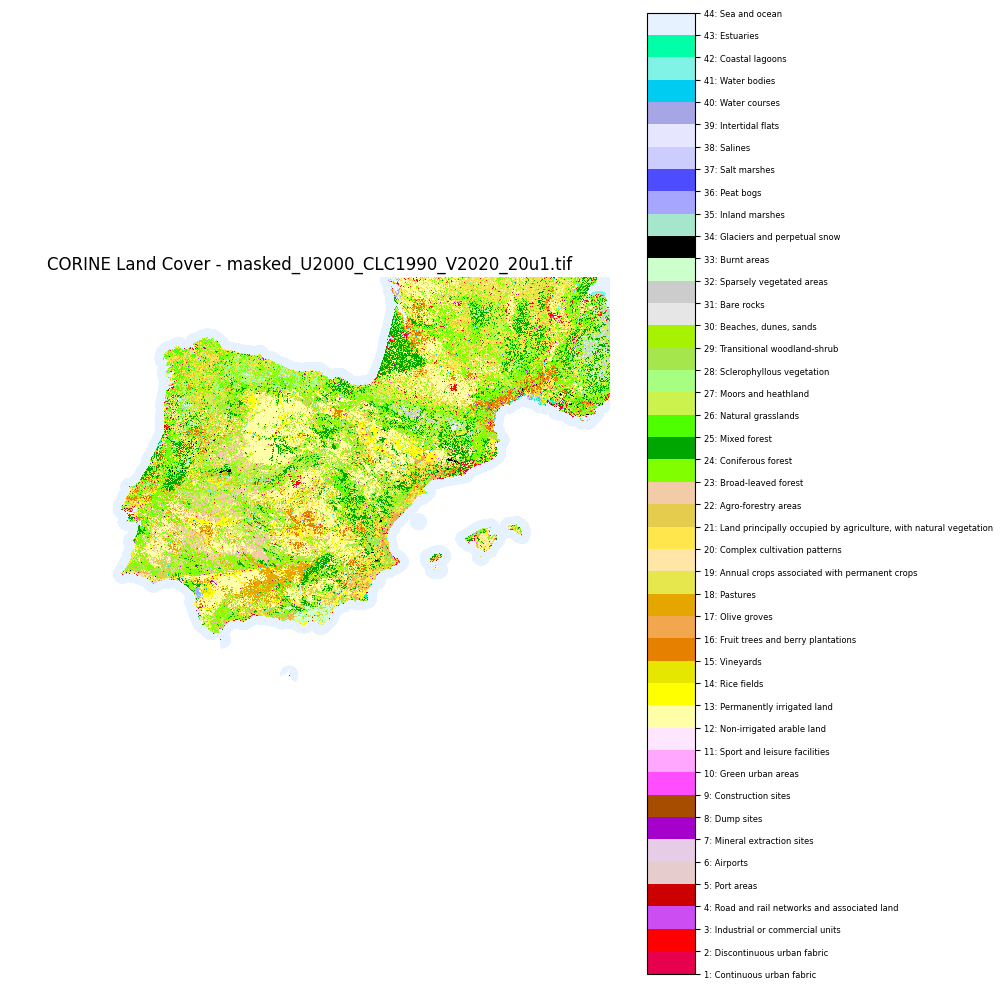

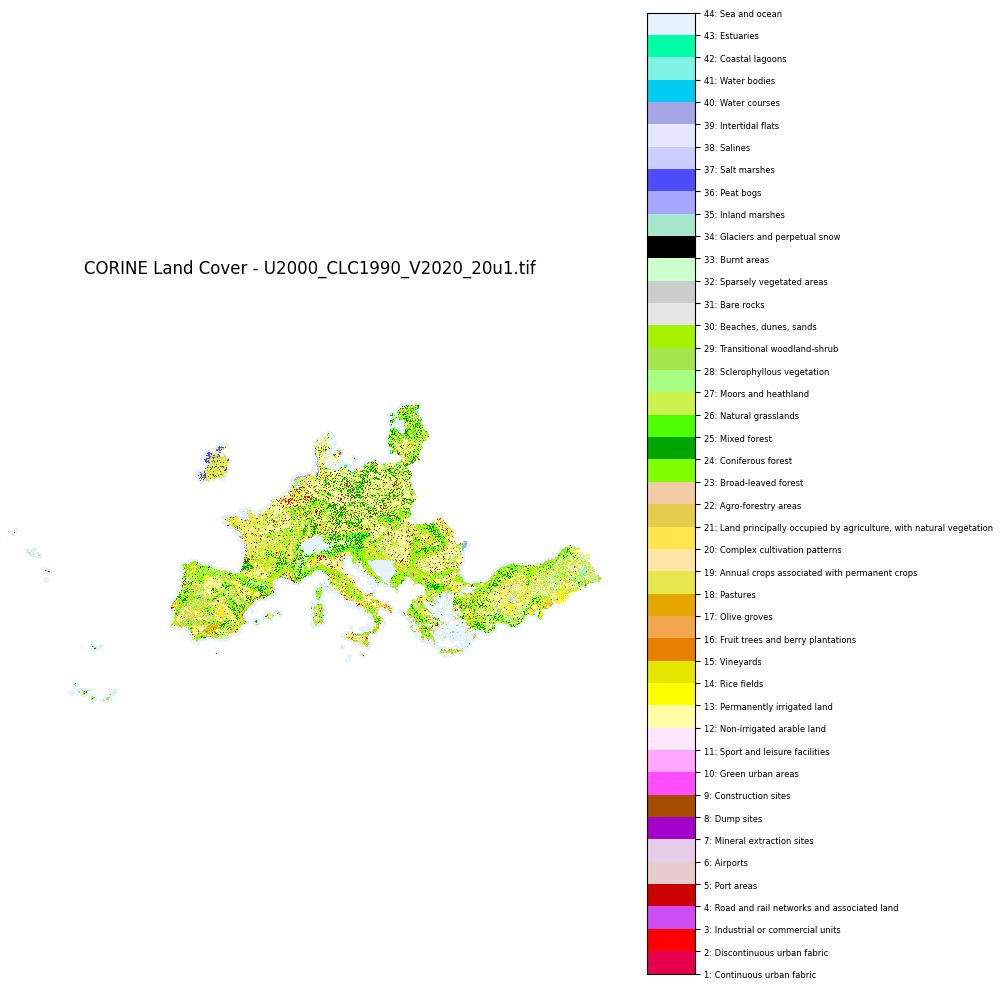

In [12]:

plot_corine_map(r"C:\Users\sabel\OneDrive\Escritorio\Master\VD\master-VD\data\processed_data\CORINE Land Cover Masked\masked_U2000_CLC1990_V2020_20u1.tif",clc_legend, clc_descriptions)
plot_corine_map(r"C:\Users\sabel\OneDrive\Escritorio\Master\VD\master-VD\data\raw_data\CORINE Land Cover\U2000_CLC1990_V2020_20u1.tif",clc_legend, clc_descriptions)


#### Emisiones

Este dataset, obtenido de la base de datos FAOSTAT de la Organización de las Naciones Unidas para la Alimentación y la Agricultura (FAO) ([FAOSTAT - Emissions totals](https://www.fao.org/faostat/en/#data/GT)), contiene información sobre las emisiones de gases de efecto invernadero en España a lo largo del tiempo. Los datos están desglosados por tipo de gas (CO₂, CH₄, N₂O, entre otros) y expresados en diferentes unidades, incluyendo equivalentes de CO₂ según el Quinto Informe de Evaluación (AR5) del IPCC. Cada registro representa una estimación de emisiones asociada a una fuente específica dentro del sector agrícola o del uso del suelo, identificada en la columna "Item" (por ejemplo, residuos de cultivos, suelos agrícolas, fermentación entérica del ganado, entre otros). Además, se incluyen detalles sobre el método de estimación empleado, la unidad de medida y posibles indicadores de calidad del dato. Este dataset permite analizar la evolución de las emisiones y su impacto en el calentamiento global.

Data description: https://files-faostat.fao.org/production/GT/GT_en.pdf

In [24]:
csv_path = raw_data_path+'\\FAOSTAT_data_en_3-13-2025.csv'
df_emision = pd.read_csv(csv_path)
df_emision.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Source Code,Source,Unit,Value,Flag,Flag Description,Note
0,GT,Emissions totals,724,Spain,7234,Direct emissions (N2O),5064,Crop Residues,1961,1961,3050,FAO TIER 1,kt,1.9911,E,Estimated value,NaN
1,GT,Emissions totals,724,Spain,7236,Indirect emissions (N2O),5064,Crop Residues,1961,1961,3050,FAO TIER 1,kt,0.4480,E,Estimated value,NaN
2,GT,Emissions totals,724,Spain,7230,Emissions (N2O),5064,Crop Residues,1961,1961,3050,FAO TIER 1,kt,2.4391,E,Estimated value,NaN
3,GT,Emissions totals,724,Spain,724313,Emissions (CO2eq) from N2O (AR5),5064,Crop Residues,1961,1961,3050,FAO TIER 1,kt,646.3615,E,Estimated value,NaN
4,GT,Emissions totals,724,Spain,723113,Emissions (CO2eq) (AR5),5064,Crop Residues,1961,1961,3050,FAO TIER 1,kt,646.3615,E,Estimated value,NaN


Estudio de los valores nulos.

In [42]:
# Valores nulos por columna
print(f"\nValores nulos en cada columna:\n{df_emision.isnull().sum()}")


Valores nulos en cada columna:
Domain Code            0
Domain                 0
Area Code (M49)        0
Area                   0
Element Code           0
Element                0
Item Code              0
Item                   0
Year Code              0
Year                   0
Source Code            0
Source                 0
Unit                   0
Value                  0
Flag                   0
Flag Description       0
Note                6138
dtype: int64


Debido a la forma de extracción del dataset de la web de FAOSTAT es posible que existan muchas columnas con valores únicos que no aportan información real. Estos datasets serán eliminados.

In [43]:
# Valores únicos en columnas categóricas
print(f"\nValores únicos en columnas categóricas:")
for col in df_emision.columns:
    print(f"{col}: {df_emision[col].nunique()} valores únicos")
    if df_emision[col].nunique() == 1:
        print(f"-> Valor único: {df_emision[col].iloc[0]}")


Valores únicos en columnas categóricas:
Domain Code: 1 valores únicos
-> Valor único: GT
Domain: 1 valores únicos
-> Valor único: Emissions totals
Area Code (M49): 1 valores únicos
-> Valor único: 724
Area: 1 valores únicos
-> Valor único: Spain
Element Code: 9 valores únicos
Element: 9 valores únicos
Item Code: 30 valores únicos
Item: 30 valores únicos
Year Code: 62 valores únicos
Year: 62 valores únicos
Source Code: 1 valores únicos
-> Valor único: 3050
Source: 1 valores únicos
-> Valor único: FAO TIER 1
Unit: 1 valores únicos
-> Valor único: kt
Value: 4945 valores únicos
Flag: 1 valores únicos
-> Valor único: E
Flag Description: 1 valores únicos
-> Valor único: Estimated value
Note: 0 valores únicos


Para el preprocesado eliminamos las Variables que no aportan información, es decir, aquellas que están vacías en todos los registros (Note) o no aportan ningún tipo de información porque tienen un único valor (Por ejemplo, Area Code y Area, ya que nos hemos limitado a los datos de España). Antes de eliminar estas columnas, nos fijamos en la información que nos aportan.


*   **Domain** y **Domain Code**. Los datos agrupan totales de emisiones por pais segregados por sectores.
*   **Area** y **Area Code**. Todos los registros son de emisiones en España.
*   **Source** y **Source Code**. La fuente de estos datos es la base de datos de la Organización de las Naciones Unidas para la Alimentación y la Agricultura.
*   **Unit**. Las emisiones se contabilizan en kt (kilotoneladas).
*   **Flag** y **Flag Description**. Todos los valores están estimados.


In [45]:
for col in df_emision.columns:
    if df_emision[col].nunique()==1:
      df_emision=df_emision.drop(col, axis=1);
      print(f"{col} eliminado\n")

Domain Code eliminado

Domain eliminado

Area Code (M49) eliminado

Area eliminado

Source Code eliminado

Source eliminado

Unit eliminado

Flag eliminado

Flag Description eliminado



Por ultimo, regularizamos tanto las entradas como los nombres de las columnas. En el siguietne bloque se estandarizan los nombres de las columns para eliminar espacios, convertir todo a minúsculas y eliminar símbolos  especiales. Ademas, se realiza un proceso similar sobre las columnas categóricas, de modo que se eviten erroes como que exitan dos clases llamadas 'Industria' e 'industria' respectivalemnte.  Este es un procedimiento general el cualquier proyecto que conlleve el tratamiento de datasets.

In [ ]:
# Regularización de los nombres de las columnas
df_emision.columns = (
    df_emision.columns
    .str.strip()                    
    .str.lower()                   
    .str.replace(' ', '_')         
    .str.replace(r'[^\w\s]', '', regex=True) 
)
# regularización de las variables categóricas
cat_cols = df_emision.select_dtypes(include='object').columns

for col in cat_cols:
    df_emision[col] = (
        df_emision[col]
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace(r'[^\w\s]', '', regex=True)
    )



In [ ]:
output_path = processed_data_path+'//emisionesFAOSTA.csv'
df_emision.to_csv(output_path, index=False, encoding='utf-8')
print(f"Archivo guardado correctamente en: {output_path}")

Archivo guardado correctamente en: C:\Users\sabel\OneDrive\Escritorio\Master\VD\master-VD\data\processed_data\emisionesFAOSTATcsv


#### Datos sintéticos de condiciones atomosféricas

Para agrerar profundidad a nuestro proyecto se ha decidico generar un conjunto de datos sintéticos con la temperatura, humedad y precipitaciones en cada provincia de españa diariamente. Para que los datos obtenidos sean más relistas se ha clasificado cada provincia en cuatro zonas: norte, costa mediterránea, centro y sur. En base a esas provincias se generaron unos parámetros base para cada provincia sobre los cuales construír los datos sintéticos. Además, se ha tenido en consideración las cuatro estaciones del año para adaptar los datos generados.

In [ ]:
provincias = [
    'Álava', 'Albacete', 'Alicante', 'Almería', 'Asturias', 'Ávila', 'Badajoz', 'Barcelona',
    'Burgos', 'Cáceres', 'Cádiz', 'Cantabria', 'Castellón', 'Ciudad Real', 'Córdoba', 'La Coruña',
    'Cuenca', 'Gerona', 'Granada', 'Guadalajara', 'Guipúzcoa', 'Huelva', 'Huesca', 'Islas Baleares',
    'Jaén', 'León', 'Lérida', 'Lugo', 'Madrid', 'Málaga', 'Murcia', 'Navarra', 'Orense', 'Palencia',
    'Las Palmas', 'Pontevedra', 'La Rioja', 'Salamanca', 'Santa Cruz de Tenerife', 'Segovia', 'Sevilla',
    'Soria', 'Tarragona', 'Teruel', 'Toledo', 'Valencia', 'Valladolid', 'Vizcaya', 'Zamora', 'Zaragoza',
    'Ceuta', 'Melilla'
]

# Clima base por provincia (simplificado: norte, centro, sur, costa)
np.random.seed(42)
zonas_climaticas = {
    'norte': {'temp': 11, 'hum': 80, 'prec': 3.5},
    'centro': {'temp': 14, 'hum': 60, 'prec': 1.5},
    'sur': {'temp': 18, 'hum': 50, 'prec': 1.0},
    'costa_mediterranea': {'temp': 16, 'hum': 70, 'prec': 2.0}
}

# Asignación simplificada de provincias a zonas
zona_provincia = {
    'norte': ['Álava', 'Asturias', 'Cantabria', 'Guipúzcoa', 'Vizcaya', 'Lugo', 'La Coruña', 'Orense', 'Pontevedra'],
    'centro': ['Madrid', 'Ávila', 'Salamanca', 'Segovia', 'Soria', 'Zamora', 'Valladolid', 'Palencia', 'Burgos', 'Cuenca', 'Guadalajara', 'Toledo', 'Ciudad Real'],
    'sur': ['Sevilla', 'Córdoba', 'Jaén', 'Granada', 'Almería', 'Málaga', 'Huelva', 'Badajoz'],
    'costa_mediterranea': ['Barcelona', 'Valencia', 'Alicante', 'Castellón', 'Tarragona', 'Gerona', 'Murcia', 'Cádiz', 'Islas Baleares', 'Las Palmas', 'Santa Cruz de Tenerife', 'Melilla', 'Ceuta']
}

# Crear diccionario de parámetros base para cada provincia
parametros_provincias = {}
for prov in provincias:
    for zona, provincias_zona in zona_provincia.items():
        if prov in provincias_zona:
            base = zonas_climaticas[zona]
            parametros_provincias[prov] = {
                'temp_base': base['temp'] + np.random.normal(0, 1),
                'humedad_base': base['hum'] + np.random.normal(0, 5),
                'precipitacion_base': base['prec'] + np.random.normal(0, 0.5)
            }
            break
    else:  # default centro si no está clasificada
        base = zonas_climaticas['centro']
        parametros_provincias[prov] = {
            'temp_base': base['temp'] + np.random.normal(0, 1),
            'humedad_base': base['hum'] + np.random.normal(0, 5),
            'precipitacion_base': base['prec'] + np.random.normal(0, 0.5)
        }

# Generar fechas
fechas = pd.date_range(start='1968-01-01', end='2016-12-31', freq='D')

# Generar el dataset
data = []
for fecha in fechas:
    mes = fecha.month
    ajuste_estacional = np.sin((mes - 1) / 12 * 2 * np.pi) * 10  # ciclo anual
    for prov in provincias:
        base = parametros_provincias[prov]
        temp_media = base['temp_base'] + ajuste_estacional + np.random.normal(0, 1)
        temp_min = temp_media - np.random.uniform(2, 6)
        temp_max = temp_media + np.random.uniform(2, 6)
        humedad = np.clip(base['humedad_base'] + np.random.normal(0, 10), 20, 100)
        precipitacion = max(0, np.random.normal(base['precipitacion_base'], 1))

        data.append({
            'fecha': fecha,
            'provincia': prov,
            'temperatura_media': round(temp_media, 1),
            'temperatura_min': round(temp_min, 1),
            'temperatura_max': round(temp_max, 1),
            'humedad': round(humedad, 1),
            'precipitacion': round(precipitacion, 2)
        })

df_clima = pd.DataFrame(data)
df_clima.head()


,fecha,provincia,temperatura_media,temperatura_min,temperatura_max,humedad,precipitacion
0,1968-01-01,Álava,13.4,8.8,16.3,84.0,2.85
1,1968-01-01,Albacete,16.3,13.0,21.3,68.5,1.80
2,1968-01-01,Alicante,18.4,16.0,21.9,92.8,0.88
3,1968-01-01,Almería,17.7,11.8,21.3,50.4,1.59
4,1968-01-01,Asturias,11.3,6.9,15.2,85.0,3.26


Como los datos han sido generados ad hoc para este proyecto, no será necesario realizar ningún preprocesamiento específico. La única transformación que realizaremos será la regularización de los nombres de las provicias pra evitar erores posteriores.

In [ ]:

df_clima['provincia'] = df_clima['provincia'].apply(lambda x: unidecode(str(x).lower()))

In [ ]:
output_path = processed_data_path+"//dataClima.csv""
os.makedirs(os.path.dirname(output_path), exist_ok=True)
# f_clima.to_csv(output_path, index=False, encoding='utf-8')
print(f"Archivo guardado correctamente en: {output_path}")

Archivo guardado correctamente en: C:\Users\sabel\OneDrive\Escritorio\Master\VD\master-VD\data\processed_data\dataClima.csv


### Datos demográficos


Por último, se ha incorporado un conjunto de datos demográficos que recoge la evolución de la población por provincia y año. Este dataset, obtenido del Instituto Nacional de Estadística (INE), permite explorar la posible relación entre la densidad de población y la incidencia de incendios, así como analizar cómo la presión humana sobre el territorio puede influir en el número, la extensión o la frecuencia de los siniestros forestales.
*Fuente:* https://www.ine.es/jaxiT3/Tabla.htm?t=2852

In [33]:
path=raw_data_path+"//dataDemografica.csv"
df_dem = pd.read_csv(path, sep=";", encoding="latin1")

############## Regularización ##############
df_dem['Provincias'] = df_dem['Provincias'].apply(lambda x: unidecode(str(x).lower()))

############## Filtrado o selección de columnas ##############

# Eliminar filas donde 'Provincias' sea 'total' porque no nos están aportando información que poder comparar con los incedios
df_dem = df_dem[df_dem['Provincias'] != 'total']
# Eliminar la columna Sexo ya que en todos los datos es total
df_dem = df_dem.drop(columns=['Sexo'])
# Eliminar filas donde 'Total' es nulo y el año es 1997
df_dem = df_dem[~((df_dem['Periodo'] == 1997))]

df_dem



,Provincias,Periodo,Total
21,02 albacete,2016,392.118
22,02 albacete,2015,394.580
23,02 albacete,2014,396.987
24,02 albacete,2013,400.007
25,02 albacete,2012,402.837
...,...,...,...
1107,52 melilla,2001,68.789
1108,52 melilla,2000,66.263
1109,52 melilla,1999,56.929
1110,52 melilla,1998,60.108


In [34]:

# Limpiar nombres provincia
df_dem['Provincias'] = df_dem['Provincias'].str.lower().str.strip()

# Convertir columna 'Total' a entero (quitando puntos si es necesario)
df_dem['Total'] = df_dem['Total'].str.replace('.', '', regex=False).astype(int)

# Función para clasificar según percentiles de cada año
def clasificar_por_ano(df):
    p33 = df['Total'].quantile(0.33)
    p66 = df['Total'].quantile(0.66)
    def clasifica(pob):
        if pob < p33:
            return 'rural'
        elif pob > p66:
            return 'urbana'
        else:
            return 'semiurbana'
    return df.assign(categoria=df['Total'].apply(clasifica))

# Aplicar agrupando por año
df_dem = df_dem.groupby('Periodo', group_keys=False).apply(clasificar_por_ano)
# Mostrar resultado
print(df_dem[['Periodo', 'Provincias', 'Total', 'categoria']].head(20))

    Periodo   Provincias   Total   categoria
21     2016  02 albacete  392118  semiurbana
22     2015  02 albacete  394580  semiurbana
23     2014  02 albacete  396987  semiurbana
24     2013  02 albacete  400007  semiurbana
25     2012  02 albacete  402837  semiurbana
26     2011  02 albacete  402318  semiurbana
27     2010  02 albacete  401682  semiurbana
28     2009  02 albacete  400891  semiurbana
29     2008  02 albacete  397493  semiurbana
30     2007  02 albacete  392110  semiurbana
31     2006  02 albacete  387658  semiurbana
32     2005  02 albacete  384640  semiurbana
33     2004  02 albacete  379448  semiurbana
34     2003  02 albacete  376556  semiurbana
35     2002  02 albacete  371787  semiurbana
36     2001  02 albacete  367283  semiurbana
37     2000  02 albacete  363263  semiurbana
38     1999  02 albacete  361021  semiurbana
39     1998  02 albacete  358597  semiurbana
41     1996  02 albacete  359010  semiurbana


C:\Users\sabel\AppData\Local\Temp\ipykernel_8844\3165482807.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dem = df_dem.groupby('Periodo', group_keys=False).apply(clasificar_por_ano)


Como obervamos que no existen datos demográficos del año 1997, eliminamo esta fecha de nuestro dataset y guardamos archivo procesado.

In [35]:
df_dem = df_dem[df_dem['Periodo'] != 1997]
output_path= processed_data_path+"//dataDemografica_processed.csv"
df_dem.to_csv(output_path, index=False, sep=";")